In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12,6)


In [3]:
# Đọc dữ liệu Samsung
df = pd.read_csv('Samsung_clean.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1/4/2010,16060,16180,16000,16180,11978.36523,11950800
1,1/5/2010,16520,16580,16300,16440,12170.84668,27925850
2,1/6/2010,16580,16820,16520,16820,12452.17090,22948850
3,1/7/2010,16820,16820,16260,16260,12037.59082,22107950
4,1/8/2010,16400,16420,16120,16420,12156.04102,14777550


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3892 entries, 0 to 3891
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3892 non-null   object 
 1   Open       3892 non-null   int64  
 2   High       3892 non-null   int64  
 3   Low        3892 non-null   int64  
 4   Close      3892 non-null   int64  
 5   Adj Close  3892 non-null   float64
 6   Volume     3892 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 213.0+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.reset_index(drop=True)
df.tail()


,Date,Open,High,Low,Close,Adj Close,Volume
3887,2025-10-23,96800,98500,96300,96500,96500.0,18488581
3888,2025-10-24,97900,99000,97700,98800,98800.0,18801925
3889,2025-10-27,101300,102000,100600,102000,102000.0,22169970
3890,2025-10-28,100900,101000,99100,99500,99500.0,20002282
3891,2025-10-29,100200,101000,99100,100500,100500.0,20899788


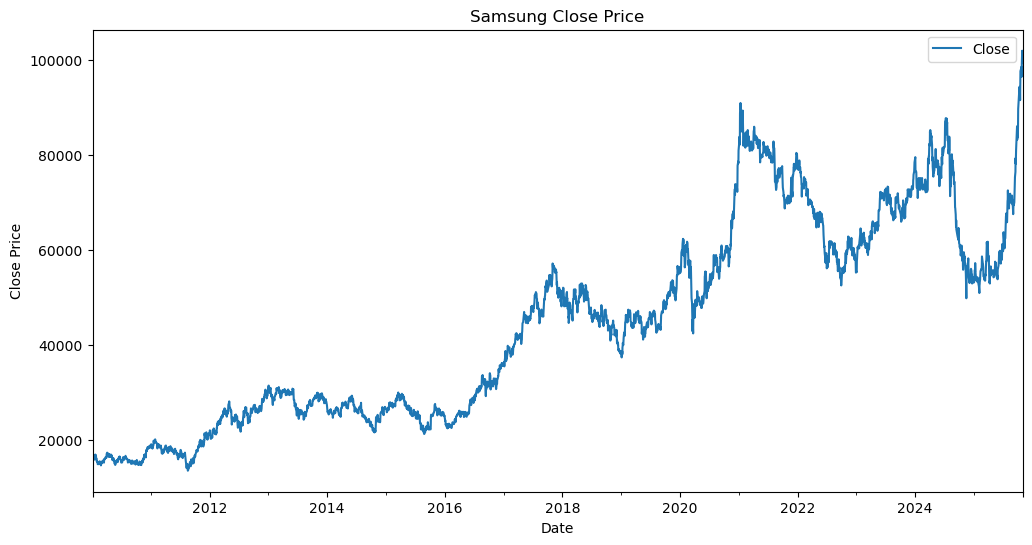

In [6]:
data = df[['Date', 'Close']].copy()
data.set_index('Date', inplace=True)
data = data.asfreq('D')  # gán tần suất ngày (Daily)
data = data.interpolate() # nội suy nếu có missing
data.plot(title='Samsung Close Price', ylabel='Close Price')
plt.show()


In [7]:
n = len(data)
train_size = int(n * 0.6)
val_size = int(n * 0.2)

train = data.iloc[:train_size]
val = data.iloc[train_size:train_size+val_size]
test = data.iloc[train_size+val_size:]

print(f"Train: {train.shape}, Validation: {val.shape}, Test: {test.shape}")


Train: (3466, 1), Validation: (1155, 1), Test: (1157, 1)


In [9]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    msle = mean_squared_log_error(y_true, np.maximum(y_pred, 1e-6))
    return mse, mape, rmse, msle


In [10]:
alphas = np.arange(0.1, 1.1, 0.1)
results = []

for alpha in alphas:
    model = SimpleExpSmoothing(train['Close'], initialization_method='heuristic').fit(smoothing_level=alpha, optimized=False)
    pred_val = model.forecast(len(val))
    mse, mape, rmse, msle = evaluate_model(val['Close'], pred_val)
    results.append((alpha, mse, mape, rmse, msle))

results_df = pd.DataFrame(results, columns=['Alpha', 'MSE', 'MAPE', 'RMSE', 'MSLE'])
results_df


,Alpha,MSE,MAPE,RMSE,MSLE
0,0.1,5.272357e+08,0.271405,22961.614361,0.149468
1,0.2,5.028833e+08,0.262391,22425.059613,0.140349
2,0.3,4.939220e+08,0.259076,22224.355683,0.137046
3,0.4,4.902109e+08,0.257708,22140.707364,0.135687
4,0.5,4.888859e+08,0.257218,22110.764431,0.135203
5,0.6,4.887609e+08,0.257172,22107.936759,0.135157
6,0.7,4.892037e+08,0.257336,22117.949018,0.135319
7,0.8,4.898416e+08,0.257571,22132.364411,0.135552
8,0.9,4.904709e+08,0.257804,22146.576588,0.135782
9,1.0,4.910088e+08,0.258003,22158.717824,0.135979


In [11]:
best_alpha = results_df.loc[results_df['MSE'].idxmin(), 'Alpha']
print("Best alpha:", best_alpha)


Best alpha: 0.6


In [12]:
model_best = SimpleExpSmoothing(train['Close'], initialization_method='estimated').fit(smoothing_level=best_alpha, optimized=False)
pred_val = model_best.forecast(len(val))

mse_val, mape_val, rmse_val, msle_val = evaluate_model(val['Close'], pred_val)
print(f"Validation -> MSE: {mse_val:.2f}, MAPE: {mape_val:.4f}, RMSE: {rmse_val:.2f}, MSLE: {msle_val:.6f}")


Validation -> MSE: 488760867.73, MAPE: 0.2572, RMSE: 22107.94, MSLE: 0.135157


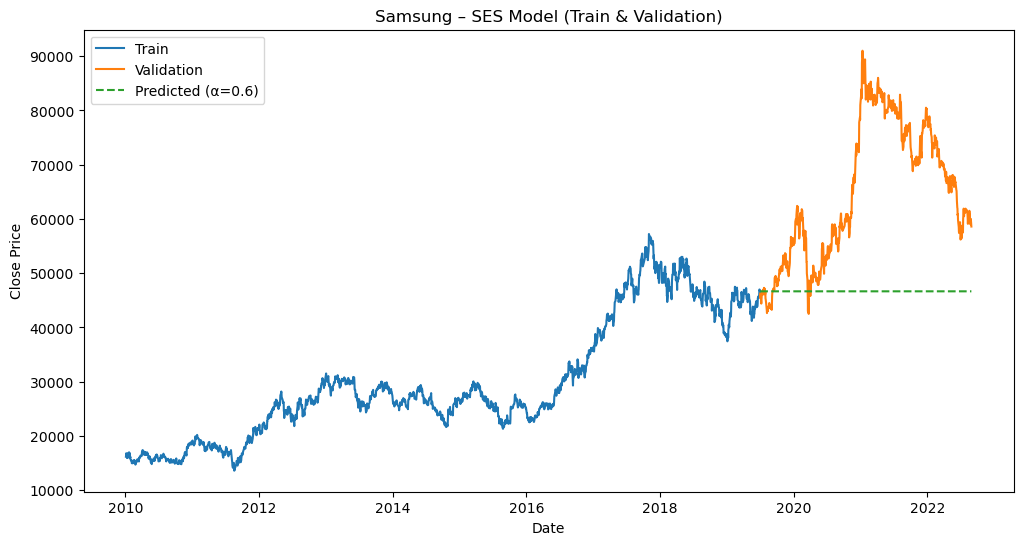

In [13]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(val.index, val['Close'], label='Validation')
plt.plot(val.index, pred_val, label=f'Predicted (α={best_alpha})', linestyle='--')
plt.title('Samsung – SES Model (Train & Validation)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [14]:
full_train_val = pd.concat([train, val])
model_test = SimpleExpSmoothing(full_train_val['Close'], initialization_method='estimated').fit(smoothing_level=best_alpha, optimized=False)
pred_test = model_test.forecast(len(test))

mse_t, mape_t, rmse_t, msle_t = evaluate_model(test['Close'], pred_test)
print(f"Test -> MSE: {mse_t:.2f}, MAPE: {mape_t:.4f}, RMSE: {rmse_t:.2f}, MSLE: {msle_t:.6f}")


Test -> MSE: 163188623.35, MAPE: 0.1331, RMSE: 12774.53, MSLE: 0.034678


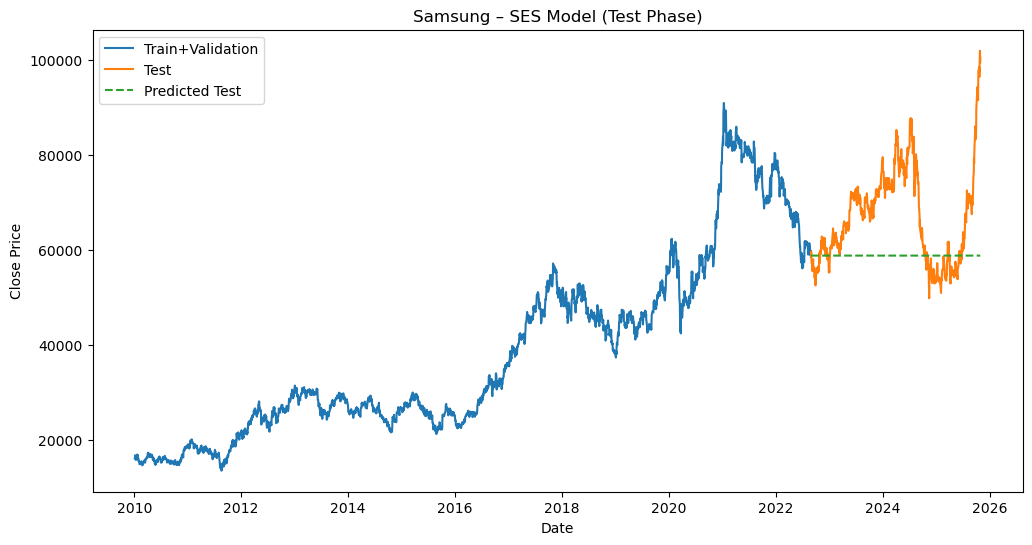

In [15]:
plt.figure(figsize=(12,6))
plt.plot(full_train_val.index, full_train_val['Close'], label='Train+Validation')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, pred_test, label='Predicted Test', linestyle='--')
plt.title('Samsung – SES Model (Test Phase)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


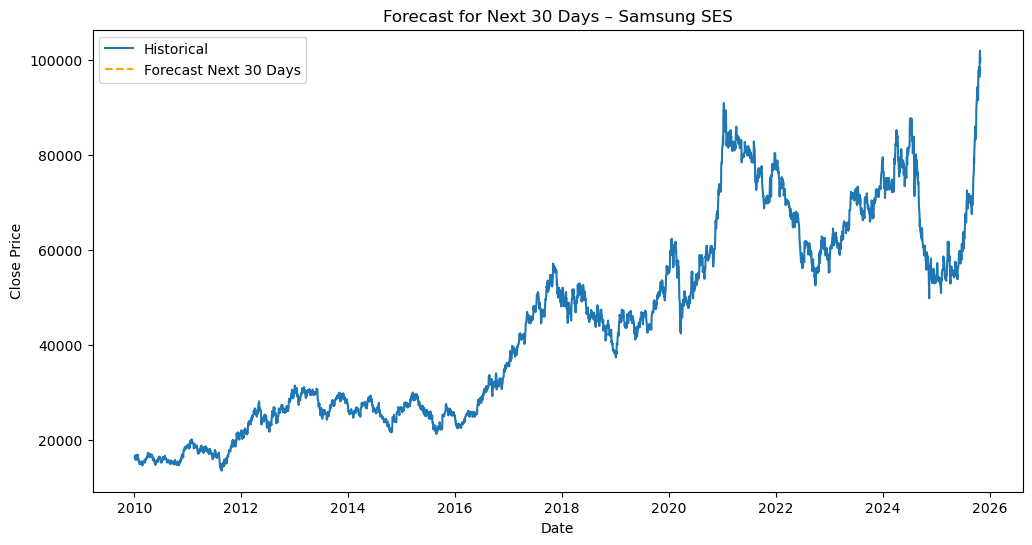

2025-10-30   NaN
2025-10-31   NaN
2025-11-01   NaN
2025-11-02   NaN
2025-11-03   NaN
Freq: D, dtype: float64

In [16]:
forecast_30 = model_test.forecast(30)
index_future = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_series = pd.Series(forecast_30, index=index_future)

plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label='Historical')
plt.plot(forecast_series.index, forecast_series.values, label='Forecast Next 30 Days', linestyle='--', color='orange')
plt.title('Forecast for Next 30 Days – Samsung SES')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

forecast_series.head()


In [17]:
summary = pd.DataFrame({
    'Phase': ['Validation', 'Test'],
    'MSE': [mse_val, mse_t],
    'MAPE': [mape_val, mape_t],
    'RMSE': [rmse_val, rmse_t],
    'MSLE': [msle_val, msle_t]
})
summary


,Phase,MSE,MAPE,RMSE,MSLE
0,Validation,4.887609e+08,0.257172,22107.936759,0.135157
1,Test,1.631886e+08,0.133095,12774.530259,0.034678


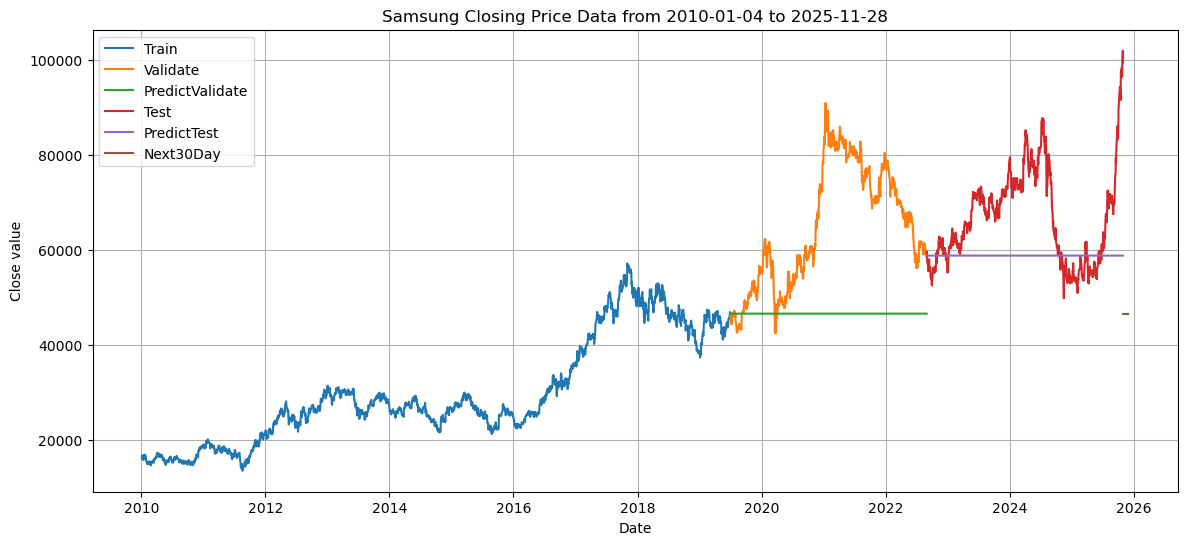

In [19]:
# Visualization (giống file CTLT.ipynb)
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa lại dữ liệu để vẽ đúng tỷ lệ
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Chia lại dữ liệu chuẩn hóa để vẽ
train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]

# Dự báo trên Validation và Test đã có sẵn
best_model = SimpleExpSmoothing(train['Close'], initialization_method='estimated').fit(smoothing_level=best_alpha, optimized=False)
best_y_pred_val = best_model.forecast(len(val))
best_y_pred_test = SimpleExpSmoothing(pd.concat([train, val])['Close'], initialization_method='estimated').fit(smoothing_level=best_alpha, optimized=False).forecast(len(test))

# Chuẩn hóa các mảng dự báo để vẽ trên cùng thang đo
best_y_pred_val_scaled = scaler.transform(np.array(best_y_pred_val).reshape(-1, 1))
best_y_pred_test_scaled = scaler.transform(np.array(best_y_pred_test).reshape(-1, 1))

# Tạo dữ liệu dự báo 30 ngày tới
forecast_30 = best_model.forecast(30)
index_next_30_days = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_scaled = scaler.transform(np.array(forecast_30).reshape(-1, 1))

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))

# Train
plt.plot(data.index[:train_size], scaler.inverse_transform(train_data).flatten(), label='Train')
# Validate
plt.plot(data.index[train_size:train_size + val_size], scaler.inverse_transform(val_data).flatten(), label='Validate')
# Predict Validate
plt.plot(data.index[train_size:train_size + val_size], best_y_pred_val, label='PredictValidate')
# Test
plt.plot(data.index[train_size + val_size:], scaler.inverse_transform(test_data).flatten(), label='Test')
# Predict Test
plt.plot(data.index[train_size + val_size:], best_y_pred_test, label='PredictTest')
# Forecast 30 Days
plt.plot(index_next_30_days, forecast_30, label='Next30Day')

plt.legend(['Train', 'Validate', 'PredictValidate', 'Test', 'PredictTest', 'Next30Day'])
plt.grid()
plt.title(f"Samsung Closing Price Data from {data.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig("SES_Samsung.png")
plt.show()
